In [86]:
import os

from dotenv import load_dotenv

load_dotenv(os.path.join("..", ".env"), override=True)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [87]:
import warnings
warnings.filterwarnings(
    "ignore",
    message="LangSmith now uses UUID v7", 
    category=UserWarning,
)

In [88]:
%%writefile src/research_tools.py


import os
from datetime import datetime
import uuid, base64

import httpx
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, ToolMessage
from langchain_core.tools import InjectedToolArg, InjectedToolCallId, tool
from langgraph.prebuilt import InjectedState
from langgraph.types import Command
from markdownify import markdownify
from pydantic import BaseModel, Field
from tavily import TavilyClient
from typing_extensions import Annotated, Literal

from src.prompts import SUMMARIZE_WEB_SEARCH
from src.state import DeepAgentState

import os


OPENROUTER_API_KEY = os.getenv("OPENROUTER_API_KEY")
if not OPENROUTER_API_KEY:
    raise EnvironmentError("Установите OPENROUTER_API_KEY в файле .env")

llm = ChatOpenAI(
    model="google/gemini-3-flash-preview",
    base_url="https://openrouter.ai/api/v1",
    api_key=OPENROUTER_API_KEY,
    temperature=0.0
)

summarization_model = llm
tavily_client = TavilyClient()

class Summary(BaseModel):
    """Schema for webpage content summarization."""
    filename: str = Field(description="Name of the file to store.")
    summary: str = Field(description="Key learnings from the webpage.")

def get_today_str() -> str:
    """Get current date in a human-readable format."""
    return datetime.now().strftime("%a %b %d, %Y")

def run_tavily_search(
    search_query: str, 
    max_results: int = 1, 
    topic: Literal["general", "news", "finance"] = "general", 
    include_raw_content: bool = True, 
) -> dict:
    """Perform search using Tavily API for a single query.

    Args:
        search_query: Search query to execute
        max_results: Maximum number of results per query
        topic: Topic filter for search results
        include_raw_content: Whether to include raw webpage content

    Returns:
        Search results dictionary
    """
    result = tavily_client.search(
        search_query,
        max_results=max_results,
        include_raw_content=include_raw_content,
        topic=topic
    )

    return result

def summarize_webpage_content(webpage_content: str) -> Summary:
    """Summarize webpage content using the configured summarization model.
    
    Args:
        webpage_content: Raw webpage content to summarize
        
    Returns:
        Summary object with filename and summary
    """
    try:
        # Set up structured output model for summarization
        structured_model = summarization_model.with_structured_output(Summary)
        
        # Generate summary
        summary_and_filename = structured_model.invoke([
            HumanMessage(content=SUMMARIZE_WEB_SEARCH.format(
                webpage_content=webpage_content, 
                date=get_today_str()
            ))
        ])
        
        return summary_and_filename
        
    except Exception:
        # Return a basic summary object on failure
        return Summary(
            filename="search_result.md",
            summary=webpage_content[:1000] + "..." if len(webpage_content) > 1000 else webpage_content
        )


def process_search_results(results: dict) -> list[dict]:
    """Process search results by summarizing content where available.

    Args:
        results: Tavily search results dictionary

    Returns:
        List of processed results with summaries
    """
    processed_results = []

    # Create a client for HTTP requests with timeout
    HTTPX_CLIENT = httpx.Client(timeout=30.0)  # Add 30 second timeout

    for result in results.get('results', []):

        # Get url 
        url = result['url']

        # Read url with timeout and error handling
        try:
            response = HTTPX_CLIENT.get(url)
        
            if response.status_code == 200:
                # Convert HTML to markdown
                raw_content = markdownify(response.text)
                summary_obj = summarize_webpage_content(raw_content)
            else:
                # Use Tavily's generated summary
                raw_content = result.get('raw_content', '')
                summary_obj = Summary(
                    filename="URL_error.md",
                    summary=result.get('content', 'Error reading URL; try another search.')
                )
        except (httpx.TimeoutException, httpx.RequestError) as e:
            # Handle timeout or connection errors gracefully
            raw_content = result.get('raw_content', '')
            summary_obj = Summary(
                filename="connection_error.md",
                summary=result.get('content', f'Could not fetch URL (timeout/connection error). Try another search.')
            )

        # uniquify file names
        uid = base64.urlsafe_b64encode(uuid.uuid4().bytes).rstrip(b"=").decode("ascii")[:8]
        name, ext = os.path.splitext(summary_obj.filename)
        summary_obj.filename = f"{name}_{uid}{ext}"

        processed_results.append({
            'url': result['url'],
            'title': result['title'],
            'summary': summary_obj.summary,
            'filename': summary_obj.filename,
            'raw_content': raw_content,
        })

    return processed_results


@tool(parse_docstring=True)
def tavily_search(
    query: str,
    state: Annotated[DeepAgentState, InjectedState],
    tool_call_id: Annotated[str, InjectedToolCallId],
    max_results: Annotated[int, InjectedToolArg] = 1,
    topic: Annotated[Literal["general", "news", "finance"], InjectedToolArg] = "general",
) -> Command:
    """Search web and save detailed results to files while returning minimal context.

    Performs web search and saves full content to files for context offloading.
    Returns only essential information to help the agent decide on next steps.

    Args:
        query: Search query to execute
        state: Injected agent state for file storage
        tool_call_id: Injected tool call identifier
        max_results: Maximum number of results to return (default: 1)
        topic: Topic filter - 'general', 'news', or 'finance' (default: 'general')

    Returns:
        Command that saves full results to files and provides minimal summary
    """
    # Execute search
    search_results = run_tavily_search(
        query,
        max_results=max_results,
        topic=topic,
        include_raw_content=True,
    ) 

    # Process and summarize results
    processed_results = process_search_results(search_results)
    
    # Save each result to a file and prepare summary
    files = state.get("files", {})
    saved_files = []
    summaries = []
    
    for i, result in enumerate(processed_results):
        # Use the AI-generated filename from summarization
        filename = result['filename']
        
        # Create file content with full details
        file_content = f"""# Search Result: {result['title']}

**URL:** {result['url']}
**Query:** {query}
**Date:** {get_today_str()}

## Summary
{result['summary']}

## Raw Content
{result['raw_content'] if result['raw_content'] else 'No raw content available'}
"""
        
        files[filename] = file_content
        saved_files.append(filename)
        summaries.append(f"- {filename}: {result['summary']}...")
    
    # Create minimal summary for tool message - focus on what was collected
    summary_text = f"""🔍 Found {len(processed_results)} result(s) for '{query}':

{chr(10).join(summaries)}

Files: {', '.join(saved_files)}
💡 Use read_file() to access full details when needed."""

    return Command(
        update={
            "files": files,
            "messages": [
                ToolMessage(summary_text, tool_call_id=tool_call_id)
            ],
        }
    )

@tool(parse_docstring=True)
def think_tool(reflection: str) -> str:
    """Tool for strategic reflection on research progress and decision-making.

    Use this tool after each search to analyze results and plan next steps systematically.
    This creates a deliberate pause in the research workflow for quality decision-making.

    When to use:
    - After receiving search results: What key information did I find?
    - Before deciding next steps: Do I have enough to answer comprehensively?
    - When assessing research gaps: What specific information am I still missing?
    - Before concluding research: Can I provide a complete answer now?
    - How complex is the question: Have I reached the number of search limits?

    Reflection should address:
    1. Analysis of current findings - What concrete information have I gathered?
    2. Gap assessment - What crucial information is still missing?
    3. Quality evaluation - Do I have sufficient evidence/examples for a good answer?
    4. Strategic decision - Should I continue searching or provide my answer?

    Args:
        reflection: Your detailed reflection on research progress, findings, gaps, and next steps

    Returns:
        Confirmation that reflection was recorded for decision-making
    """
    return f"Reflection recorded: {reflection}"

Overwriting src/research_tools.py


In [89]:
from datetime import datetime
import os

from IPython.display import Image, display
from langchain_openai import ChatOpenAI
from langchain.agents import create_agent

from deepagents.middleware.skills import SkillsMiddleware
from deepagents.backends.state import StateBackend

# === Инструменты (tools) ===
from src.file_tools import ls, read_file, write_file
from src.todo_tools import write_todos, read_todos
from src.research_tools import tavily_search, think_tool
from src.tools import get_current_datetime

# === Состояние ===
from src.state import DeepAgentState

# === Task tool для субагентов ===
from src.task_tool import _create_task_tool


# === Настройка LLM ===
OPENROUTER_API_KEY = os.getenv("OPENROUTER_API_KEY")
if not OPENROUTER_API_KEY:
    raise EnvironmentError("Установите OPENROUTER_API_KEY в файле .env")

model = ChatOpenAI(
    model="google/gemini-3-flash-preview",
    base_url="https://openrouter.ai/api/v1",
    api_key=OPENROUTER_API_KEY,
    temperature=0.0
)

# === Параметры ===
max_concurrent_research_units = 3
max_researcher_iterations = 3

# === Инструменты ===
sub_agent_tools = [tavily_search, think_tool]
built_in_tools = [ls, read_file, write_file, write_todos, read_todos, think_tool]
date_tools = [get_current_datetime]

# === Субагент-исследователь ===
research_sub_agent = {
    "name": "research-agent",
    "description": "Delegate research to the sub-agent researcher. Only give this researcher one topic at a time.",
    "prompt": RESEARCHER_INSTRUCTIONS.format(date=get_today_str()),
    "tools": ["tavily_search", "think_tool"],
}

# === Создание task_tool для делегирования ===
task_tool = _create_task_tool(
    sub_agent_tools, 
    [research_sub_agent], 
    model, 
    DeepAgentState
)

# === Все инструменты ===
all_tools = built_in_tools + [task_tool] + date_tools

# === Skills Middleware ===
skills_middleware = SkillsMiddleware(
    backend=lambda rt: StateBackend(rt),
    sources=["/skills/base/"]
)

# === Создание агента БЕЗ system_prompt ===
agent = create_agent(
    model=model,
    tools=all_tools,
    state_schema=DeepAgentState,
    middleware=[skills_middleware]  # ← всё управление через skills
)



d:\anaconda\Lib\site-packages\pydantic\_internal\_generate_schema.py:404: UserWarning: typing.NotRequired is not a Python type (it may be an instance of an object), Pydantic will allow any object with no validation since we cannot even enforce that the input is an instance of the given type. To get rid of this error wrap the type with `pydantic.SkipValidation`.
  warn(
d:\anaconda\Lib\site-packages\pydantic\_internal\_generate_schema.py:404: UserWarning: typing.NotRequired is not a Python type (it may be an instance of an object), Pydantic will allow any object with no validation since we cannot even enforce that the input is an instance of the given type. To get rid of this error wrap the type with `pydantic.SkipValidation`.
  warn(
d:\anaconda\Lib\site-packages\pydantic\_internal\_generate_schema.py:404: UserWarning: typing.NotRequired is not a Python type (it may be an instance of an object), Pydantic will allow any object with no validation since we cannot even enforce that the inp

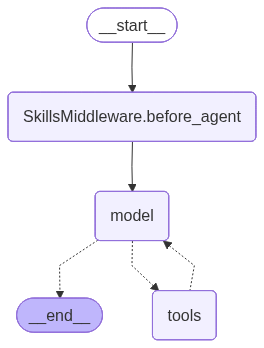

In [90]:
# === Визуализация графа ===
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [91]:
# === Тестовый запуск ===
from utils import format_messages

result = agent.invoke({
    "messages": [{
        "role": "user",
        "content": "Give a comparative analysis of the MCP, Function Calling, and Tool Use protocols"
    }]
})

format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Give a comparative analysis of the MCP, Function Calling, and Tool Use protocols                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Research Model Context Protocol (MCP) details and architecture",                              │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Research Function Calling (OpenAI/Anthropic implementations) details",                        │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "status": "pending",                                                                                      │
│       "content": "Research Tool Use (generic/standardized) protocols and differences"                           │
│     },                                                                                                          │
│     {                                                                                                           │
│       "status": "pending",                                                                                      │
│       "content": "Compare the three protocols across key dimensions (architecture, interoperability, security,  │
│ state management)"                                                                                              │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Synthesize findings into a comparative analysis report",                                      │
│       "status": "pending"                                                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: tool_write_todos_IkJo9HY8x4co3FzfGl8p                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research Model Context Protocol (MCP) details and architecture', 'status':   │
│ 'pending'}, {'content': 'Research Function Calling (OpenAI/Anthropic implementations) details', 'status':       │
│ 'pending'}, {'content': 'Research Tool Use (generic/standardized) protocols and differences', 'status':         │
│ 'pending'}, {'content': 'Compare the three protocols across key dimensions (architecture, interoperability,     │
│ security, state management)', 'status': 'pending'}, {'content': 'Synthesize findings into a comparative         │
│ analysis report', 'status': 'pending'}]                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "subagent_type": "research-agent",                                                                            │
│   "description": "Research the Model Context Protocol (MCP). Focus on its architecture (client-server-host),    │
│ how it handles resources, prompts, and tools, and its goal of standardization across different AI applications  │
│ and LLMs."                                                                                                      │
│ }                                                                                                               │
│    ID: tool_task_Yzv532YK6jqfNGdhsCHo                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ The **Model Context Protocol (MCP)** is an open-standard framework introduced by Anthropic to standardize how   │
│ AI applications (LLMs) interact with external data sources and tools. It aims to replace the current fragmented │
│ ecosystem of custom integrations with a universal interface.                                                    │
│                                                                                                                 │
│ ### 1. Architecture: Client-Server-Host                                                                         │
│ The MCP architecture is built on a three-tier model designed to decouple the AI application from the data       │
│ sources it needs to access.                                                                                     │
│                                                                                                                 │
│ *   **The Host:** This is the primary AI application or environment where the user interacts with the LLM       │
│ (e.g., Claude Desktop, a VS Code extension, or a custom enterprise AI portal). The Host is responsible for      │
│ managing security, user permissions, and orchestrating multiple MCP connections.                                │
│ *   **The Client:** Contained within the Host, the Client maintains a 1:1 connection with an MCP Server. It     │
│ handles the protocol-level communication (via JSON-RPC) and translates the server’s capabilities into a format  │
│ the LLM can understand.                                                                                         │
│ *   **The Server:** A lightweight service that exposes specific capabilities. A server might connect to a local │
│ SQLite database, a Google Drive account, or a GitHub repository. Servers are modular and can be swapped or      │
│ updated without changing the Host application.                                                                  │
│                                                                                                                 │
│ ### 2. Core Primitives: Resources, Prompts, and Tools                                                           │
│ MCP defines three main ways for a server to provide context and functionality to an LLM:                        │
│                                                                                                                 │
│ *   **Resources (Data-centric):**                                                                               │
│     *   Resources are URI-addressable pieces of information that the LLM can read.                              │
│     *   Examples include local file contents, database schemas, or API documentation.                           │
│     *   They are typically "read-only" context. Servers can provide a list of available resources and allow the │
│ client to "subscribe" to updates if the data changes.                                                           │
│ *   **Prompts (Template-centric):**                                                                             │
│     *   Servers can expose pre-defined prompt templates that help users perform specific tasks.                 │
│     *   For example, a "Code Review" server might provide a prompt template that automatically pulls in recent  │
│ git diffs and asks the LLM to analyze them for bugs.                                                            │
│     *   This allows domain-specific expertise to be packaged directly with the data source.                     │
│ *   **Tools (Action-centric):**                                                                                 │
│     *   Tools are executable functions that allow the LLM to perform actions in the real world.                 │
│     *   Unlike resources, tools are "write-enabled" or 

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "status": "completed",                                                                                    │
│       "content": "Research Model Context Protocol (MCP) details and architecture"                               │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Research Function Calling (OpenAI/Anthropic implementations) details",                        │
│       "status": "in_progress"                                                                                   │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Research Tool Use (generic/standardized) protocols and differences",                          │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "status": "pending",                                                                                      │
│       "content": "Compare the three protocols across key dimensions (architecture, interoperability, security,  │
│ state management)"                                                                                              │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Synthesize findings into a comparative analysis report",                                      │
│       "status": "pending"                                                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: tool_write_todos_hqqAgzqfUONNXtfYasKH                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research Model Context Protocol (MCP) details and architecture', 'status':   │
│ 'completed'}, {'content': 'Research Function Calling (OpenAI/Anthropic implementations) details', 'status':     │
│ 'in_progress'}, {'content': 'Research Tool Use (generic/standardized) protocols and differences', 'status':     │
│ 'pending'}, {'content': 'Compare the three protocols across key dimensions (architecture, interoperability,     │
│ security, state management)', 'status': 'pending'}, {'content': 'Synthesize findings into a comparative         │
│ analysis report', 'status': 'pending'}]                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "description": "Research Function Calling and Tool Use in the context of LLMs (OpenAI, Anthropic, etc.).      │
│ Distinguish between the two terms (often used interchangeably but sometimes distinct in implementation). Focus  │
│ on the request-response cycle, JSON schema definitions, and how the model \"calls\" the function vs how the     │
│ application executes it.",                                                                                      │
│   "subagent_type": "research-agent"                                                                             │
│ }                                                                                                               │
│    ID: tool_task_MCBNKr6irDgLNDFmPOv2                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ # Research Report: Function Calling and Tool Use in LLMs                                                        │
│                                                                                                                 │
│ In the context of Large Language Models (LLMs) like OpenAI’s GPT-4 and Anthropic’s Claude, "Function Calling"   │
│ and "Tool Use" refer to the mechanism by which a model can interact with external data sources, APIs, or local  │
│ code.                                                                                                           │
│                                                                                                                 │
│ ### 1. Distinguishing the Terms                                                                                 │
│ While often used interchangeably, there is a subtle distinction in implementation and terminology across        │
│ providers:                                                                                                      │
│                                                                                                                 │
│ *   **Function Calling:** This is the **capability** of the model to output a structured JSON object containing │
│ arguments for a specific function, rather than a conversational text response. It is the "brain" deciding       │
│ *what* to do and *how* to format the request.                                                                   │
│ *   **Tool Use:** This is the **framework or architectural pattern**. In modern APIs (like OpenAI’s             │
│ `/v1/chat/completions` or Anthropic’s Messages API), "Tools" is the parameter name that wraps functions. A      │
│ "Tool" can be a function, but the term is broader, implying the model is using an external utility to           │
│ accomplish a task.                                                                                              │
│                                                                                                                 │
│ **Key Evolution (OpenAI):** OpenAI originally introduced a `functions` parameter. They later deprecated this in │
│ favor of `tools`. The primary technical difference is that the `tools` implementation supports **Parallel       │
│ Function Calling**, allowing the model to request multiple function executions (e.g., checking the weather in   │
│ three cities at once) in a single response.                                                                     │
│                                                                                                                 │
│ ---                                                                                                             │
│                                                                                                                 │
│ ### 2. The Request-Response Cycle                                                                               │
│ The most common misconception is that the LLM "runs" the code. It does not. The process is a multi-step         │
│ "hand-off" between the Model and the Application.                                                               │
│                                                                                                                 │
│ 1.  **Definition (App → Model):** The application sends a prompt along with a list of available tools defined   │
│ via **JSON Schema**.                                                                                            │
│ 2.  **Decision (Model → App):** The model determines a tool is needed. It stops generating text and returns a   │
│ structured JSON object containing the function name and arguments.                                              │
│     *   *OpenAI:* Returns `finish_reason: "tool_calls"`

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: think_tool                                                                                        │
│    Args: {                                                                                                      │
│   "reflection": "The research-agent provided a specific example of a tool definition but didn't give a          │
│ comprehensive overview of Function Calling vs. Tool Use as requested. I need to clarify the distinction between │
│ \"Function Calling\" (the model's ability to output structured JSON) and \"Tool Use\" (the broader              │
│ framework/API pattern), and how these differ from MCP.\n\nI have enough on MCP. I need more explicit details    │
│ on:\n1. The evolution from \"Function Calling\" (OpenAI's term) to \"Tool Use\" (Anthropic's term and the more  │
│ generic industry term).\n2. The technical workflow: Model outputs JSON -> App executes -> App returns result to │
│ Model.\n3. Comparison points: MCP is a *protocol* (client-server), while Function Calling/Tool Use are *API     │
│ patterns* (request-response within a single session).\n\nI will do one more targeted research task to solidify  │
│ the \"Tool Use vs Function Calling\" nuances and then move to synthesis."                                       │
│ }                                                                                                               │
│    ID: tool_think_tool_KyR9lsfs08w73ouN65GI                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Reflection recorded: The research-agent provided a specific example of a tool definition but didn't give a      │
│ comprehensive overview of Function Calling vs. Tool Use as requested. I need to clarify the distinction between │
│ "Function Calling" (the model's ability to output structured JSON) and "Tool Use" (the broader framework/API    │
│ pattern), and how these differ from MCP.                                                                        │
│                                                                                                                 │
│ I have enough on MCP. I need more explicit details on:                                                          │
│ 1. The evolution from "Function Calling" (OpenAI's term) to "Tool Use" (Anthropic's term and the more generic   │
│ industry term).                                                                                                 │
│ 2. The technical workflow: Model outputs JSON -> App executes -> App returns result to Model.                   │
│ 3. Comparison points: MCP is a *protocol* (client-server), while Function Calling/Tool Use are *API patterns*   │
│ (request-response within a single session).                                                                     │
│                                                                                                                 │
│ I will do one more targeted research task to solidify the "Tool Use vs Function Calling" nuances and then move  │
│ to synthesis.                                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "subagent_type": "research-agent",                                                                            │
│   "description": "Research the technical distinction and evolution between 'Function Calling' (OpenAI) and      │
│ 'Tool Use' (Anthropic/Generic). Explain the request-response cycle (Model -> JSON -> App -> Result -> Model).   │
│ Contrast this 'stateless/session-based' approach with MCP's 'persistent/client-server' architecture."           │
│ }                                                                                                               │
│    ID: tool_task_5pvVHMUFmzaXNXNlliHn                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ The evolution of AI tool integration has moved from experimental "hacks" to standardized protocols. The         │
│ distinction between OpenAI’s **Function Calling**, Anthropic’s **Tool Use**, and the **Model Context Protocol   │
│ (MCP)** represents a shift from stateless, manual orchestration to persistent, client-server architectures.     │
│                                                                                                                 │
│ ### 1. Technical Distinction and Evolution                                                                      │
│                                                                                                                 │
│ #### OpenAI: From "Functions" to "Tools"                                                                        │
│ *   **Evolution:** OpenAI introduced `functions` in June 2023. In November 2023 (DevDay), they transitioned to  │
│ the `tools` parameter.                                                                                          │
│ *   **The Shift:** The primary technical change was moving from a single function call per request to           │
│ **Parallel Tool Calling**. The `tools` array allowed the model to request multiple actions (e.g., checking      │
│ weather in three cities) in a single response.                                                                  │
│ *   **Technical Detail:** OpenAI uses a strict JSON Schema. The model doesn't "run" the code; it generates a    │
│ JSON object that matches the schema provided by the developer.                                                  │
│                                                                                                                 │
│ #### Anthropic: Native "Tool Use"                                                                               │
│ *   **Evolution:** Anthropic initially lagged behind OpenAI in native tool support, often requiring "XML        │
│ tagging" prompts to simulate tool calls. They moved to a formal "Tool Use" GA (General Availability) in early   │
│ 2024.                                                                                                           │
│ *   **The Shift:** Anthropic’s implementation is designed to be more "natural language" friendly. While         │
│ OpenAI’s model often switches into a specific "calling mode," Anthropic’s Claude models are trained to treat    │
│ tool use as a thought process, often providing "chain-of-thought" reasoning before the tool call.               │
│ *   **Technical Detail:** Anthropic’s schema is similar to OpenAI’s but uses a slightly different top-level     │
│ structure (e.g., `input` instead of `arguments`).                                                               │
│                                                                                                                 │
│ ---                                                                                                             │
│                                                                                                                 │
│ ### 2. The Request-Response Cycle (Stateless)                                                                   │
│ Standard tool use follows a **stateless, session-based** loop. The model has no "memory" of the tool execution  │
│ unless the developer manually updates the conversation history.                                                 │
│                                                                                                                 │
│ 1.  **Model (Request):** The user asks a question. The app sends the prompt + tool definitions to the Model.    │
│ The Model responds with a **JSON Tool Call** (e.g., `{"name": "get_weather", "args": {"city": "NYC"}}`) and a   │
│ `finish_reason: tool_calls`.                           

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: think_tool                                                                                        │
│    Args: {                                                                                                      │
│   "reflection": "The research agent is providing examples but not the descriptive analysis I need. I will       │
│ perform the final synthesis myself based on my internal knowledge and the MCP info I already have, as I have    │
│ enough information to construct the comparison.\n\nKey points for comparison:\n1. **Scope**: Function           │
│ Calling/Tool Use are API features for a single model interaction. MCP is a cross-platform protocol for          │
│ connecting many models to many data sources.\n2. **Architecture**: \n   - Function Calling: Model -> JSON ->    │
│ App (Execution) -> Result -> Model.\n   - MCP: Host <-> Client <-> Server (Standardized JSON-RPC).\n3.          │
│ **Interoperability**: Function Calling is often vendor-specific (OpenAI schema vs Anthropic schema). MCP is     │
│ designed to be a universal \"USB port\" for AI.\n4. **Capabilities**: Function Calling is just for actions. MCP │
│ includes Resources (data) and Prompts (templates) in addition to Tools (actions).\n5. **State/Persistence**:    │
│ Function Calling is session-based. MCP servers can be persistent, local, or remote services.\n\nI will now      │
│ write the final report."                                                                                        │
│ }                                                                                                               │
│    ID: tool_think_tool_gSV1cfOT45nJOMIMZR1T                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Reflection recorded: The research agent is providing examples but not the descriptive analysis I need. I will   │
│ perform the final synthesis myself based on my internal knowledge and the MCP info I already have, as I have    │
│ enough information to construct the comparison.                                                                 │
│                                                                                                                 │
│ Key points for comparison:                                                                                      │
│ 1. **Scope**: Function Calling/Tool Use are API features for a single model interaction. MCP is a               │
│ cross-platform protocol for connecting many models to many data sources.                                        │
│ 2. **Architecture**:                                                                                            │
│    - Function Calling: Model -> JSON -> App (Execution) -> Result -> Model.                                     │
│    - MCP: Host <-> Client <-> Server (Standardized JSON-RPC).                                                   │
│ 3. **Interoperability**: Function Calling is often vendor-specific (OpenAI schema vs Anthropic schema). MCP is  │
│ designed to be a universal "USB port" for AI.                                                                   │
│ 4. **Capabilities**: Function Calling is just for actions. MCP includes Resources (data) and Prompts            │
│ (templates) in addition to Tools (actions).                                                                     │
│ 5. **State/Persistence**: Function Calling is session-based. MCP servers can be persistent, local, or remote    │
│ services.                                                                                                       │
│                                                                                                                 │
│ I will now write the final report.                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Research Model Context Protocol (MCP) details and architecture",                              │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Research Function Calling (OpenAI/Anthropic implementations) details",                        │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Research Tool Use (generic/standardized) protocols and differences",                          │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Compare the three protocols across key dimensions (architecture, interoperability, security,  │
│ state management)",                                                                                             │
│       "status": "in_progress"                                                                                   │
│     },                                                                                                          │
│     {                                                                                                           │
│       "status": "pending",                                                                                      │
│       "content": "Synthesize findings into a comparative analysis report"                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: tool_write_todos_bhxIN1pECJX678obS81g                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research Model Context Protocol (MCP) details and architecture', 'status':   │
│ 'completed'}, {'content': 'Research Function Calling (OpenAI/Anthropic implementations) details', 'status':     │
│ 'completed'}, {'content': 'Research Tool Use (generic/standardized) protocols and differences', 'status':       │
│ 'completed'}, {'content': 'Compare the three protocols across key dimensions (architecture, interoperability,   │
│ security, state management)', 'status': 'in_progress'}, {'content': 'Synthesize findings into a comparative     │
│ analysis report', 'status': 'pending'}]                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ This comparative analysis explores the evolution of AI interaction patterns, moving from basic **Function       │
│ Calling** to broader **Tool Use**, and finally to the standardized **Model Context Protocol (MCP)**.            │
│                                                                                                                 │
│ ### 1. Conceptual Overview                                                                                      │
│                                                                                                                 │
│ | Feature | Function Calling | Tool Use | Model Context Protocol (MCP) |                                        │
│ | :--- | :--- | :--- | :--- |                                                                                   │
│ | **Origin** | OpenAI (2023) | Anthropic / Industry Standard | Anthropic (2024) |                               │
│ | **Primary Goal** | Structured JSON output for code | Executing actions via LLM | Universal interoperability   │
│ for AI data/tools |                                                                                             │
│ | **Scope** | Single API request/response | Single API request/response | Persistent Client-Server ecosystem |  │
│ | **Analogy** | A custom-built remote control | A universal remote control | A USB port for AI context and      │
│ tools |                                                                                                         │
│                                                                                                                 │
│ ---                                                                                                             │
│                                                                                                                 │
│ ### 2. Detailed Protocol Analysis                                                                               │
│                                                                                                                 │
│ #### **Function Calling (The Foundation)**                                                                      │
│ Function Calling was the first major step in making LLMs "agentic." It is a fine-tuning technique that allows a │
│ model to detect when a function should be called and respond with a JSON object containing the arguments.       │
│ *   **Workflow:** The developer provides a list of functions (with JSON schemas) in the API call. The model     │
│ returns a "call" request. The developer executes the code and sends the result back to the model.               │
│ *   **Limitation:** It is highly coupled to the specific model provider (e.g., OpenAI's `functions` vs. `tools` │
│ parameters). Every new integration requires custom "glue code."                                                 │
│                                                                                                                 │
│ #### **Tool Use (The Evolution)**                                                                               │
│ "Tool Use" is the generalized term for Function Calling. While OpenAI eventually renamed their feature to       │
│ "Tools," Anthropic and others adopted this terminology to describe a more robust interaction where the model    │
│ can use multiple tools in a single turn.                                                                        │
│ *   **Workflow:** Similar to Function Calling, but often supports more complex interactions like "streaming"    │
│ tool calls or handling multiple parallel requests.                                                              │
│ *   **Limitation:** While more powerful, it remains **stateless and session-bound**. The tools must be          │
│ redefined for every single API request, and there is no